In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

import tensorflow as tf

import numpy as np
import skimage
import cv2
import scipy.io
import pprint
import glob

import PIL as pillow
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
import matplotlib


import json

import random
from sklearn.model_selection import train_test_split

import config
from data_util import *
from visualization import *
from metrics import *
from model import *

import open3d
import open3d as o3d

%matplotlib notebook

Using TensorFlow backend.


In [2]:
model_our = load_model_2()
model_our.load_weights('weights_good_loader.h5')
model_our.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:
```python
    sess = tf.Session()
    with sess.as_default():
        tensor = tf.range(10)
        print_op = tf.print(tensor)
        with tf.control_dependencies([print_op]):
          out = tf.add(tensor, tensor)
        sess.run(out)
    ```
Additionally, to use tf.print in python 2.7, users must make sure to import
the following:

  `from __future__ import print_function`

_________________________________________________________________
Layer (type)  

In [31]:
# model_our.load_weights('train_full_train.h5')
val_loss_arr = np.load('val_loss_progress.npy')
loss_arr = np.load('loss_progress.npy')

In [4]:
directory = './data_not_raw'
val_directory = './val_data_not_raw'

train_list = create_full_dir_list('./data_not_raw')['pathname_base']
val_list = create_full_dir_list('./val_data_not_raw')['pathname_base']

In [32]:
#new_version
# val_loss_arr = []
# loss_arr = []

plt.figure()
counter = 0

while True:
    H = model_our.fit_generator(generator_train_new(train_list), validation_data= return_test_new(val_list), steps_per_epoch= 60, epochs = 10)
    val_loss_arr.append(H.history['val_loss'])
    loss_arr.append(H.history['loss'])
    
    plt.ylim(0,4000)
    plt.plot(np.ravel(np.array(val_loss_arr)))
    plt.plot(np.ravel(np.array(loss_arr)))
    plt.show()
    
#     if counter%3 == 1:
    metrics_numpy_new(model_our, directory= val_directory)
    counter += 1

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
60/60 [==============================] - 51s 844ms/step - loss: -20.6392 - val_loss: 4347.0257
Epoch 2/10
60/60 [==============================] - 45s 757ms/step - loss: 529.8059 - val_loss: 7120.2619
Epoch 3/10
60/60 [==============================] - 46s 767ms/step - loss: 905.5130 - val_loss: 4605.6443
Epoch 4/10
60/60 [==============================] - 47s 778ms/step - loss: 873.7831 - val_loss: 3987.9452
Epoch 5/10
60/60 [==============================] - 47s 780ms/step - loss: 795.5174 - val_loss: 5287.5994
Epoch 6/10
60/60 [==============================] - 47s 785ms/step - loss: 1102.9973 - val_loss: 6049.0077
Epoch 7/10
60/60 [==============================] - 47s 786ms/step - loss: 131.0887 - val_loss: 7179.2480
Epoch 8/10
60/60 [==============================] - 47s 791ms/step - loss: 1260.0593 - val_loss: 6686.1935
Epoch 9/10
60/60 [==============================] - 47s 786ms/step - loss: -27.6730 - val_loss: 4742.1

AttributeError: 'numpy.ndarray' object has no attribute 'append'

<Figure size 432x288 with 0 Axes>

In [14]:
save_logs(model_our, val_loss_arr, loss_arr)

In [4]:
metrics_numpy_new(model_our, directory= val_directory)

searching in directory./val_data_not_raw
avg_iou 0.10911654758599706
recall50 0.0008333055564814507
recall75 0.0
recall50_obj 0.00722191590843347
recall75_obj 0.0
avg_obj 0.5063697791029733
avg_noobj 0.5000082483479998
avg_cat 0.19107719887505845
conf_change 380.03518176078796


In [12]:
metrics_numpy_new(model_our, './data_not_raw/')

searching in directory./data_not_raw/
avg_iou 0.3922199743157334
recall50 0.014064986401231194
recall75 0.0003691131199873683
recall50_obj 0.28773215800513985
recall75_obj 0.016622588627027434
avg_obj 0.8394108292472674
avg_noobj 0.0004700037622451121
avg_cat 0.08035710136727474
conf_change 13023.43434959086


In [6]:
metrics_numpy_targets_new(model_our, val_list)

searching in directory./val_data_not_raw/Data_30-May-2018 13-29-23/0
avg_iou 0.11925987200953989
avg_precision 0.0998168498168498
recall50 0.09621794871794871
true_counter: 130
prediction counter:  126


In [27]:
# save_logs(model_our,val_loss_arr, loss_arr)

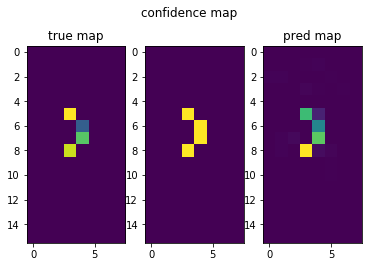

In [33]:
frame, labels, y_true = process_oneframe(train_list[10])
y_pred = model_our.predict(frame)
show_comparison_object_level(y_true, y_pred)

In [34]:
boxes = decode_netout(y_pred)
print(len(boxes))
# for i in boxes[::6]:
#     print(i)

23


In [35]:
for i in labels:
    print(i)

[ 49.         176.65240811  61.36058302  20.          16.59062104
  51.28010139  20.        ]
[ 49.         243.20342205  70.78707224  20.          13.19708492
  48.26362484  20.        ]
[ 49.         275.25348542  57.02439797  20.          16.21356147
  52.4112801   20.        ]
[ 49.         194.75126743  65.50823828  20.          12.06590621
  42.98479087  20.        ]


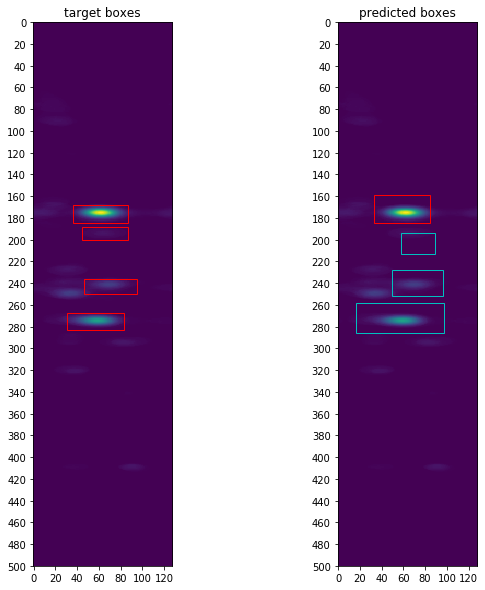

In [36]:
visualise_bird_view(frame,labels, boxes[::6])

In [30]:
metrics_numpy_targets_new(model_our, train_list[0:1], verbose= 1)

before NMS: 36
after NMS: 8
avg_iou: 0.301108075250541
precision: 0.375 , recall50: 0.75
counts 3 5 (8,)
iou_vector+ indeces: [0.57203914 0.5085261  0.56200843] [False  True False False False  True False  True]

avg_iou 0.07527701881263525
avg_precision 0.09375
recall50 0.1875
true_counter: 4
prediction counter:  8


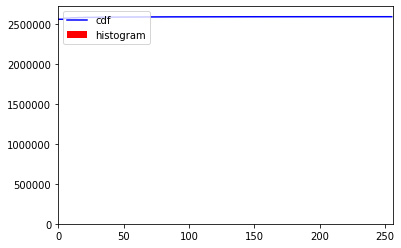

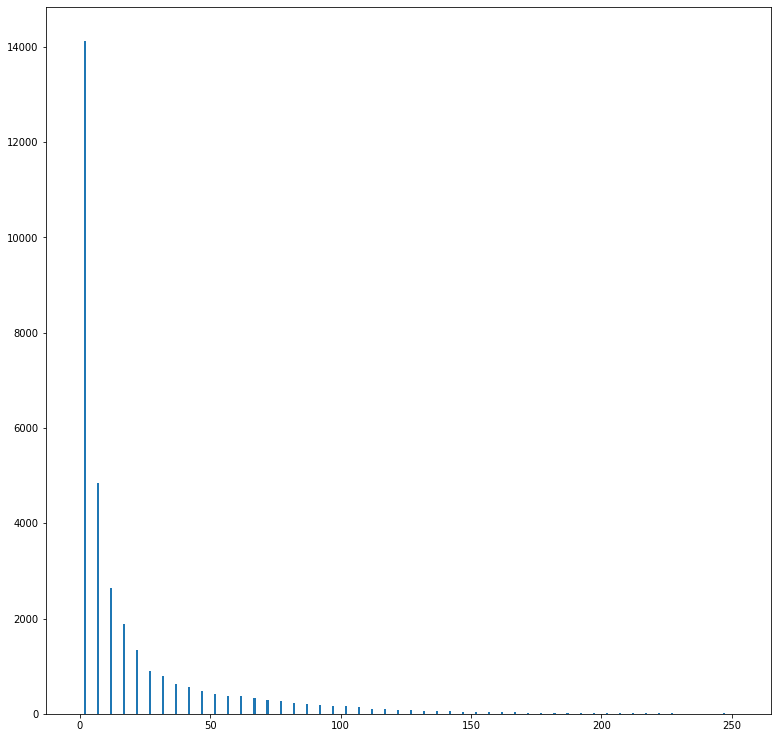

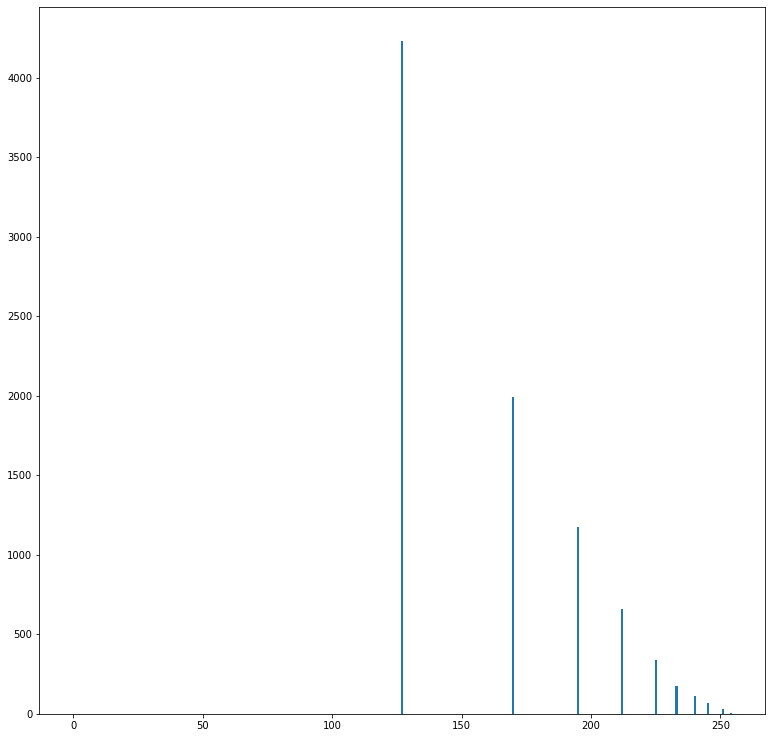

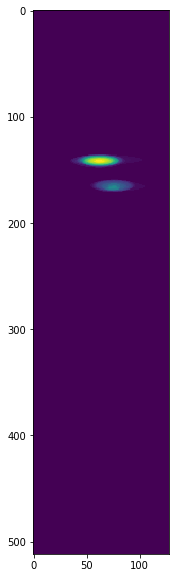

In [13]:
histogram_array = np.histogram(frame[0,...,0],bins = 256)
cdf = histogram_array[0].cumsum()
cdf_normalized = cdf*histogram_array[0].max()/cdf.max()


# print(histogram_array)

plt.plot(cdf_normalized, color = 'b')
plt.hist(frame.flatten(),256, color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')

frame_equalised = cdf[frame[0,...,0]]

plt.figure(figsize = (13,13))
plt.bar(range(len(histogram_array[0][3:])),histogram_array[0][3:])
plt.show()


histogram_array_equalised = np.histogram(frame_equalised,bins = 256)
plt.figure(figsize = (13,13))
plt.bar(range(len(histogram_array_equalised[0][1:])), histogram_array_equalised[0][1:])
plt.show()

plt.figure(figsize = (10,10))
plt.imshow(np.sum(frame_equalised,2))
plt.show()

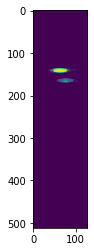

In [14]:
from skimage import data
from skimage import filters

val = filters.threshold_otsu(frame_equalised)
mask = frame_equalised > val

plt.imshow(np.sum(mask,2))

from skimage import measure
all_labels = measure.label(mask)


from skimage.morphology import watershed
from skimage.feature import peak_local_max
import skimage


from scipy import ndimage
distance = ndimage.distance_transform_edt(frame_equalised)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3,3)), labels=frame_equalised)
markers = skimage.morphology.label(local_maxi)
labels_ws = watershed(-distance, markers, mask=frame_equalised)


In [51]:
from ipywidgets import interact

# mask = mask.astype(np.int8)


def f(x):
    plt.figure(figsize = (15,15))
    if x in list(range(all_labels.shape[-1])):
        plt.imshow(all_labels[...,x])
    return x


interact(f,x = (0, all_labels.shape[-1]-1))

interactive(children=(IntSlider(value=19, description='x', max=39), Output()), _dom_classes=('widget-interact'…

<function __main__.f(x)>

In [72]:
def f(x):
    if x in list(range(labels_ws.shape[-1])):
        plt.imshow(labels_ws[...,x])
    return x

plt.figure(figsize = (9,9))
interact(f,x = (0, labels_ws.shape[-1]-1))

<Figure size 648x648 with 0 Axes>

interactive(children=(IntSlider(value=19, description='x', max=39), Output()), _dom_classes=('widget-interact'…

<function __main__.f(x)>

In [25]:
import scipy.ndimage
targets_generated = scipy.ndimage.find_objects(all_labels)
len(targets_generated)

2

In [26]:
def filtering_boxes(bounds):
    min_size = 20
    
    dim_size = [item_dim[1] - item_dim[0] for item_dim in bounds]
    
    box_prod = np.prod(dim_size)
    
    print(dim_size)
    print(box_prod)
    print(box_prod < min_size)
    if box_prod > min_size:
        return bounds
    else:
        return 0

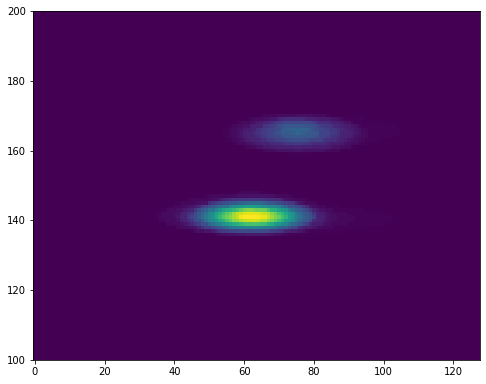

In [38]:
plt.figure(figsize = (8,8))
plt.imshow(np.sum(frame_equalised,axis = -1))
plt.ylim((100,200))
plt.show()


In [27]:
targets_matric = np.zeros((len(targets_generated), 2*N_DIM))

count = 0
bounding_boxes = []
for ind in range(len(targets_generated)):
    item = targets_generated[ind]
    bounds = [(item[j].start,item[j].stop) for j in range(len(item))]
    bounds_processed = filtering_boxes(bounds)
    if bounds_processed == 0:
        continue
    count += 1
    print(bounds)
    bbox = []
    for dim in range(len(bounds)):
        start = bounds[dim][0]
        end = bounds[dim][1]
        center = (end + start)/2
        width = (end - start)
        bbox.append([center,width])
#     print(bbox[0][0], bbox[1][0], bbox[2][0],bbox[0][1], bbox[1][1], bbox[2][1])
    bounding_boxes.append([bbox[0][0], bbox[1][0], bbox[2][0],bbox[0][1], bbox[1][1], bbox[2][1]])
    
print(count)

np.array(bounding_boxes)

[13, 68, 22]
19448
False
[(136, 149), (35, 103), (18, 40)]
[12, 51, 16]
9792
False
[(159, 171), (54, 105), (24, 40)]
2


array([[142.5,  69. ,  29. ,  13. ,  68. ,  22. ],
       [165. ,  79.5,  32. ,  12. ,  51. ,  16. ]])

[142.5, 69.0, 29.0, 13, 68, 22] 69.0 68 142.5 13
[165.0, 79.5, 32.0, 12, 51, 16] 79.5 51 165.0 12


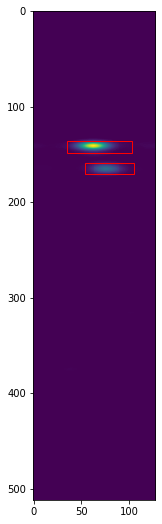

In [47]:
im = np.sum(frame,axis = (0,3,4))

fig,ax = plt.subplots(1, figsize = (9,9))

# Display the image
ax.imshow(im)


for box in bounding_boxes:
    y = box[0]
    x = box[1]
    w = box[3]
    l = box[4]
    x_t = x-l/2
    x_b = x+l/2 
    y_t = y-w/2
    y_b = y+w/2
    rect = patches.Rectangle((x_t,y_t),l,w,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

plt.show()

In [122]:
pcd = create_pointcloud(pointcloud_coords_generation(frame_equalised)[0])

bb_objects = []
bb_cords = []

for i in range(len(bounding_boxes)):
    
#     boxes_points = get_all_points(bounding_boxes[i])
#     vertices = boxes_points
    
    cx = bounding_boxes[i][0]
    cy = bounding_boxes[i][1]
    cz = bounding_boxes[i][2]
    l  = bounding_boxes[i][3]
    w  = bounding_boxes[i][4]
    h  = bounding_boxes[i][5]
    
    
    cx,cy,cz = tocartesian(cx,cy,cz)
    
    new_l = l*(67/512)
    new_w = 2*(cx+new_l/2)*np.tan(((w-64)/2)*(114/128)*np.pi/180)
    new_h = 2*(cz+new_l/2)*np.tan((h/2)*(16/40)*np.pi/180)
    
    l = new_l/2
    w = new_w/2
    h = new_h/2

    vertices = [] 

    for i in [-l,l]:
        for j in [-w,w]:
            for k in [-h,h]:
                vertices.append([cx+i,cy+j,cz+k])
                
    lines = [[0,1],[0,2],[1,3],[2,3],
         [4,5],[4,6],[5,7],[6,7],
         [0,4],[1,5],[2,6],[3,7]]
    colors = [[1, 0, 0] for i in range(len(lines))]
    line_set = o3d.geometry.LineSet()
    line_set.points = o3d.utility.Vector3dVector(vertices)
    line_set.lines = o3d.utility.Vector2iVector(lines)
    line_set.colors = o3d.utility.Vector3dVector(colors)
    bb_cords.append([cx,cy,cz,l,w,h])
    bb_objects.append(line_set)
    
o3d.visualization.draw_geometries([pcd, *bb_objects])

In [124]:
def bb_dict_create(bb_cords):
    whole_dict = {}
    whole_dict['bounding_boxes'] = []
    
    for i in range(len(bb_cords)):
        bb_dict = {}
        bb_dict.setdefault('center',{'x':0, 'y':0, 'z':0})
        
        bb_dict['center']['x']  = bb_cords[i][0]
        bb_dict['center']['y']  = bb_cords[i][1]
        bb_dict['center']['z']  = bb_cords[i][2]
        bb_dict['width'] = bb_cords[i][3]
        bb_dict['length'] = bb_cords[i][4]
        bb_dict['height'] = bb_cords[i][5]
        bb_dict['angle'] = 0
        bb_dict['object_id'] = 'car'
        
        whole_dict['bounding_boxes'].append(bb_dict)
    
    return whole_dict

In [127]:
bb_dict_create(bb_cords)

{'bounding_boxes': [{'center': {'x': 18.21144782113539,
    'y': 1.4182814981585026,
    'z': 3.749592679963082},
   'width': 0.8505859375,
   'length': 0.5928044115111635,
   'height': 0.3539644536894255,
   'angle': 0,
   'object_id': 'car'},
  {'center': {'x': 20.447041537646193,
    'y': 5.024048880647653,
    'z': 4.783630158560959},
   'width': 0.78515625,
   'length': -2.1525931349264664,
   'height': 0.31134349624239666,
   'angle': 0,
   'object_id': 'car'}]}

In [ ]:
json.

In [104]:
def get_all_points(box):
    cx = box[0]
    cy = box[1]
    cz = box[2]
    l = box[3]/2
    w = box[4]/2
    h = box[5]/2
    
    points = [] 
    
    for i in [-l,l]:
        for j in [-w,w]:
            for k in [-h,h]:
                points.append(tocartesian(cx+i, cy+j, cz+k))
    return points


def tocartesian(R_ind,phi_ind,theta_ind):
    
    R_real = 67
    R_imagery = 512
    phi_real = 114
    phi_imagery = 128
    theta_real = 16
    theta_imagery = 40
    
    theta = theta_ind*(theta_real/theta_imagery)*np.pi/180
    phi = ((phi_ind - phi_imagery/2)*(phi_real/phi_imagery))*np.pi/180 
    R = R_ind*(R_real/R_imagery)
    
    
    x = R*np.cos(theta)*np.cos(phi)
    y = R*np.cos(theta)*np.sin(phi)
    z = R*np.sin(theta)
    
    return [x,y,z]